In [ ]:
# pip install pingouin

In [1]:
# import necessary packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm, wilcoxon
from statsmodels.stats.weightstats import ztest as ztest
from statistics import stdev

from tqdm import tqdm

from random import randint
import math
# import pingouin as pg

import warnings
warnings.filterwarnings("ignore")

import os

path = os.getcwd()
os.chdir(f"{path}")

In [17]:
# import necessary data

primdata = pd.read_csv("../Data/primdata.csv")
lastdata = pd.read_csv("../Data/lastdata.csv")
sim_mf = pd.read_csv("../Data/mfpairs_similarity.csv")
sim_mf_last = pd.read_csv("../Data/mwpairs_similarity_edited.csv")
sim_mm = pd.read_csv("../Data/mmpairs_similarity.csv")

# Similarity Analyses

## Similarity Validation Statistics

In [5]:
# first of last author analysis?

#### If primary author analysis:

data = primdata.copy()
df = sim_mf.copy()

##### If last author analysis:

# data = lastdata.copy()
# df = sim_mf_last.copy()

print("man-led: ", data.query(f'gender == "male"').doi.nunique())
print("woman-led: ", data.query(f'gender == "female"').doi.nunique())

man-led:  242287
woman-led:  30729


In [6]:
#### Filter conditions (if needed)

#### If journal condition:

# jour = 'PRL'
# sdoi = data[data['journal'] == jour].doi
# print("man-led: ", data.query(f'gender == "male" & journal == "{jour}"').doi.nunique())
# print("woman-led: ", data.query(f'gender == "female" & journal == "{jour}"').doi.nunique())

#### IF PACS condition:

cond = 0
sdoi = data[data[f'pacs{cond}0'] == 1].doi
print("man-led: ", data.query(f'gender == "male" & pacs{cond}0 == 1').doi.nunique())
print("woman-led: ", data.query(f'gender == "female" & pacs{cond}0 == 1').doi.nunique())

man-led:  48767
woman-led:  5903


In [7]:
#### Filter dataframes accordingly (skip if no filtering needed)

#### If primary analysis:

df = sim_mf[sim_mf['paper1'].isin(sdoi)]
df = df[df['paper2'].isin(sdoi)].reset_index(drop=True)

#### If last author analysis:

# df = sim_mf_last[sim_mf_last['paper1'].isin(sdoi)]
# df = df[df['paper2'].isin(sdoi)].reset_index(drop=True)

In [8]:
# filter year constraints

N = 3

df = df[df['yeard'] >= -N]
df = df[df['yeard'] <= N].reset_index(drop=True)

In [9]:
p = 0.001
df_vld = df[df['qval'] < p]

print("N: ", len(df))
print("M: ", len(df_vld))
print("M/N: ", format(len(df_vld)/len(df), ".4f"))

N:  816425
M:  95038
M/N:  0.1164


In [10]:
# getting mlist and fmlist (count per gender)

mdoi = []
wdoi = []

mlist = []
fmlist = []

for i in tqdm(range(len(df_vld))):
    if df_vld['gender1'][i] == 'male':
        mdoi.append(df_vld['paper1'][i])
        wdoi.append(df_vld['paper2'][i])
        mlist.append(df_vld['count1'][i])
        fmlist.append(df_vld['count2'][i])
    else:
        mdoi.append(df_vld['paper2'][i])
        wdoi.append(df_vld['paper1'][i])
        mlist.append(df_vld['count2'][i])
        fmlist.append(df_vld['count1'][i])

print("\n")
print("Filtered man-led papers: ", len(list(set(mdoi))))
print("Filtered woman-led papers: ", len(list(set(wdoi))))

100%|██████████| 95038/95038 [00:01<00:00, 53935.24it/s]



Filtered man-led papers:  27409
Filtered woman-led papers:  5204


In [ ]:
# Find effect size
print(format(pg.compute_effsize(mlist, fmlist, paired=True, eftype='hedges'), ".3f"))
print('')

# Find z-scores (for p-values)
zscore, pval = ztest(mlist, fmlist, value=0)
print(format(zscore, ".3f"), pval)

### Similarity Validation Statistics (Random Sampling w/o time constraints)

In [11]:
# 100 randomly sampled set with the sample size of df_vld with no time constraint,
# then compute mean and st.dev of effect size and pval per subfield

cond = 2 # subfield
N = 3    # time constraint

sdoi = primdata[primdata[f'pacs{cond}0'] == 1].doi

df_rs = sim_mf[sim_mf['paper1'].isin(sdoi)]
df_rs = df_rs[df_rs['paper2'].isin(sdoi)].reset_index(drop=True)

p = 0.001
df_rs = df_rs[df_rs['qval'] < p]

df_rs_time = df_rs[df_rs['yeard'] >= -N]
df_rs_time = df_rs_time[df_rs_time['yeard'] <= N].reset_index(drop=True)

In [ ]:
esizes = []
pvalues = []

for _ in tqdm(range(100)):
    sim_mf_rs = df_rs.copy().sample(n=len(df_rs_time)).reset_index()
    mlist = []
    fmlist = []
    for i in range(len(sim_mf_rs)):
        if sim_mf_rs['gender1'][i] == 'male':
            mlist.append(sim_mf_rs['count1'][i])
            fmlist.append(sim_mf_rs['count2'][i])
        else:
            mlist.append(sim_mf_rs['count2'][i])
            fmlist.append(sim_mf_rs['count1'][i])
    esize = pg.compute_effsize(mlist, fmlist, paired=True, eftype='hedges')
    pval = ztest(mlist, fmlist, value=0)[1]
    esizes.append(esize)
    pvalues.append(pval)

print("\n")
print("N: ", len(df_rs_time))
print("")
print("effect size (mean):", format(np.mean(esizes), ".3f"))
print("effect size (std):", format(np.std(esizes), ".3f"))
print("")
print("p-value (mean):", format(np.mean(pvalues), ".3g"))
print("p-value (std):", format(np.std(pvalues), ".3g"))

## Centrality Difference Trend by Year (m-f pairs)

In [12]:
mfs = sim_mf[sim_mf['yeard'] <= 3]
mfs = mfs[mfs['yeard'] >= -3].reset_index(drop=True)

lateryear = []

for i in tqdm(range(len(mfs))):
    lateryear.append(max(mfs['year1'][i], mfs['year2'][i]))

mfs['lateryear'] = lateryear

mfs.head()

100%|██████████| 5610758/5610758 [00:36<00:00, 152017.77it/s]


,paper1,paper2,gender1,gender2,year1,year2,keyval,qval,count1,count2,countd,yeard,lateryear
0,10.1103/PhysRevB.74.035411,10.1103/PhysRevB.75.205440,female,male,2006,2007,4,-1.117244e-10,1,1,0,1,2007
1,10.1103/PhysRevB.73.075112,10.1103/PhysRevB.74.045113,female,male,2006,2006,4,-1.117173e-10,9,2,-7,0,2006
2,10.1103/PhysRev.88.1109,10.1103/RevModPhys.24.321,male,female,1952,1952,2,-9.355250e-11,45,79,-34,0,1952
3,10.1103/PhysRevE.70.011103,10.1103/PhysRevE.70.056128,male,female,2004,2004,3,-8.545054e-11,1,1,0,0,2004
4,10.1103/PhysRevB.76.174508,10.1103/PhysRevLett.99.087001,male,female,2007,2007,3,-8.545054e-11,1,3,-2,0,2007


In [13]:
p = 0.001

simp = mfs[mfs['qval'] < p].sort_values('countd').reset_index(drop=True)
print(len(simp)/len(mfs))

simp_mw = simp[['lateryear', 'countd']].sort_values(by=['lateryear', 'countd'])

0.10214484388740346


In [14]:
simp_mw_yr = simp_mw.groupby(['lateryear'])['lateryear'].count()
simp_mw_yr.head()

lateryear
1903    3
1916    1
1918    1
1921    1
1923    2
Name: lateryear, dtype: int64

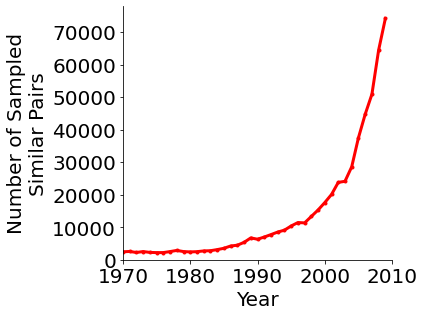

In [15]:
fig, ax = plt.subplots(figsize=(6,4.5))
right_side = ax.spines["right"]
top_side = ax.spines["top"]
right_side.set_visible(False)
top_side.set_visible(False)

simp_mw_yr.plot(style='.-',color='red', lw=3)

plt.xlabel('Year', fontsize=20)
plt.xlim(xmin=1970, xmax=2010)
plt.xticks(np.arange(1970, 2011, 10), fontsize=20)
plt.ylabel('Number of Sampled\nSimilar Pairs', fontsize=20)
plt.yticks(fontsize=20)
plt.ylim(ymin=0)

plt.tight_layout()

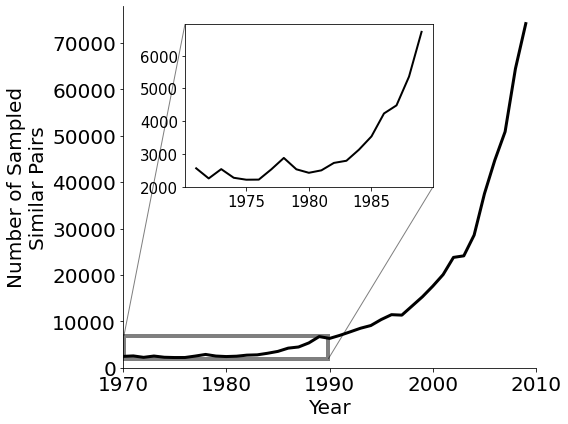

In [16]:
# inset

simp_mw_yr = pd.DataFrame({'year':simp_mw_yr.index, 'count':simp_mw_yr.values})

fig, ax = plt.subplots(figsize=(8,6))
right_side = ax.spines["right"]
top_side = ax.spines["top"]
right_side.set_visible(False)
top_side.set_visible(False)

plt.plot(simp_mw_yr['year'], simp_mw_yr['count'], color='black', lw=3)

inset_ax = ax.inset_axes([0.15, 0.5, 0.6, 0.45])
inset_ax.plot(simp_mw_yr['year'][52:71], simp_mw_yr['count'][52:71], color='black', lw=2)
inset_ax.tick_params(labelsize=15)

plt.xlabel('Year', fontsize=20)
plt.xlim(xmin=1970, xmax=2010)
plt.xticks(np.arange(1970, 2011, 10), fontsize=20)
plt.ylabel('Number of Sampled\nSimilar Pairs', fontsize=20)
plt.yticks(fontsize=20)
plt.ylim(ymin=0)
ax.indicate_inset_zoom(inset_ax, edgecolor="black", linewidth = 4)

plt.tight_layout()

## Comparing similar m-m pairs and m-w pairs

### Percentile plots of centrality difference by year

In [18]:
# man-man pairs

# apply year restriction

mms = sim_mm[sim_mm['yeard'] <= 3]
mms = mms[mms['yeard'] >= -3].reset_index(drop=True)

# label the publication year of pairs as the publication year of a latter one

lateryear = []

for i in tqdm(range(len(mms))):
    lateryear.append(max(mms['year1'][i], mms['year2'][i]))

mms['lateryear'] = lateryear

# apply similarity threshold

p = 0.001

simp_mm = mms[mms['qval'] < p].sort_values('countd').reset_index(drop=True)
print(len(simp_mm)/len(mms))

simp_mm = simp_mm[['lateryear', 'countd']].sort_values(by=['lateryear', 'countd'])

100%|██████████| 19194476/19194476 [02:07<00:00, 150081.32it/s]


0.11612294078775581


In [19]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

In [20]:
# find the percentile statistics for m-w pairs

paired_mf = simp_mw.groupby('lateryear').agg([np.mean, percentile(10), percentile(20),
                                      percentile(30), percentile(40), np.median,
                                      percentile(60), percentile(70), percentile(80),
                                      percentile(90)]).reset_index()

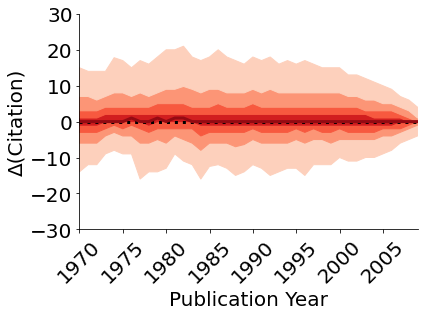

In [21]:
# m-w pair percentile plot

fig, ax = plt.subplots(figsize=(6,4.5))
right_side = ax.spines["right"]
top_side = ax.spines["top"]
right_side.set_visible(False)
top_side.set_visible(False)

cm = sns.color_palette("Reds",10)

plt.axhline(y=0, color='black', linestyle='dotted', lw=3)
plt.plot(paired_mf.lateryear,paired_mf.countd["median"],"-",label="M-F Median", color=cm[9], lw=3)

plt.fill_between(paired_mf.lateryear, paired_mf.countd["percentile_10"],
                 paired_mf.countd["percentile_20"], color=cm[1])
plt.fill_between(paired_mf.lateryear, paired_mf.countd["percentile_20"],
                 paired_mf.countd["percentile_30"], color=cm[3])
plt.fill_between(paired_mf.lateryear, paired_mf.countd["percentile_30"],
                 paired_mf.countd["percentile_40"], color=cm[5])
plt.fill_between(paired_mf.lateryear, paired_mf.countd["percentile_40"],
                 paired_mf.countd["median"], color=cm[7])
plt.fill_between(paired_mf.lateryear, paired_mf.countd["median"],
                 paired_mf.countd["percentile_60"], color=cm[7])
plt.fill_between(paired_mf.lateryear, paired_mf.countd["percentile_60"],
                 paired_mf.countd["percentile_70"], color=cm[5])
plt.fill_between(paired_mf.lateryear, paired_mf.countd["percentile_70"],
                 paired_mf.countd["percentile_80"], color=cm[3])
plt.fill_between(paired_mf.lateryear, paired_mf.countd["percentile_80"],
                 paired_mf.countd["percentile_90"], color=cm[1])

plt.xticks(fontsize=20, rotation=45)
plt.yticks(fontsize=20)
plt.xlabel("Publication Year", fontsize=20)
plt.ylabel("\u0394(Citation)", fontsize=20)

plt.xlim(xmin=1970, xmax=2009)
plt.ylim(ymin=-30, ymax=30)

plt.tight_layout()

In [22]:
ref = simp_mw.lateryear.unique()
numlist = []

mm_centrality = pd.DataFrame(columns=['lateryear'])

for num in ref:
    numlist.append(num)
mm_centrality['lateryear'] = numlist

# take the average of 100 random m-m pair samples per year and calculate the centrality difference

for k in tqdm(range(100)):
    df1 = pd.DataFrame(columns=['lateryear', 'countd'])
    vlist = []

    for i in range(len(ref)):
        df2 = simp_mm[simp_mm['lateryear'] == ref[i]].sample(
            simp_mw.lateryear.value_counts().sort_index().iloc[i], replace=True)
        df1 = pd.concat([df1,df2])
    
    for j in range(len(df1)):
        if randint(0,1) == 0:
            vlist.append(df1.countd.iloc[j])
        else:
            vlist.append(df1.countd.iloc[j] * -1)
    
    df1['value'] = vlist
    df1 = df1.groupby("lateryear").agg([np.mean]).reset_index().drop(['lateryear'], axis=1)

    mm_centrality = pd.concat([mm_centrality, df1], axis=1)

mm_centrality.head()

100%|██████████| 100/100 [07:55<00:00,  4.75s/it]


,lateryear,"(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)",...,"(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)"
0,1903,0.666667,-0.666667,0.0,0.0,-0.666667,0.666667,-0.666667,0.0,0.0,...,0.666667,-1.333333,-0.666667,1.333333,0.0,0.666667,-0.666667,0.0,0.666667,0.666667
1,1916,-1.000000,-5.000000,-4.0,-1.0,-9.000000,-5.000000,6.000000,0.0,0.0,...,-1.000000,9.000000,5.000000,-1.000000,1.0,-1.000000,-6.000000,-9.0,6.000000,0.000000
2,1918,1.000000,1.000000,1.0,-1.0,-2.000000,-14.000000,0.000000,-1.0,-14.0,...,-2.000000,11.000000,2.000000,-1.000000,0.0,0.000000,0.000000,1.0,0.000000,-1.000000
3,1921,2.000000,1.000000,-3.0,2.0,3.000000,1.000000,1.000000,3.0,0.0,...,-2.000000,3.000000,3.000000,3.000000,2.0,-3.000000,-1.000000,-3.0,1.000000,0.000000
4,1923,1.000000,4.500000,-4.0,-0.5,-0.500000,0.500000,1.000000,1.0,-1.5,...,1.500000,2.500000,0.000000,-2.000000,6.0,1.500000,-0.500000,-10.0,0.000000,-3.000000


In [23]:
# record the percentiles of the average statistics of 100 m-m pairs per year

paired_mm = mm_centrality.copy()

list_1, list_2, list_3, list_4, list_5, list_6, list_7, list_8, list_9 = [], [], [], [], [], [], [], [], []

for i in range(len(paired_mm)):
    list_1.append(np.percentile(paired_mm.iloc[i,1:],10))
    list_2.append(np.percentile(paired_mm.iloc[i,1:],20))
    list_3.append(np.percentile(paired_mm.iloc[i,1:],30))
    list_4.append(np.percentile(paired_mm.iloc[i,1:],40))
    list_5.append(np.median(paired_mm.iloc[i,1:]))
    list_6.append(np.percentile(paired_mm.iloc[i,1:],60))
    list_7.append(np.percentile(paired_mm.iloc[i,1:],70))
    list_8.append(np.percentile(paired_mm.iloc[i,1:],80))
    list_9.append(np.percentile(paired_mm.iloc[i,1:],90))

paired_mm['percentile_10'] = list_1
paired_mm['percentile_20'] = list_2
paired_mm['percentile_30'] = list_3
paired_mm['percentile_40'] = list_4
paired_mm['median'] = list_5
paired_mm['percentile_60'] = list_6
paired_mm['percentile_70'] = list_7
paired_mm['percentile_80'] = list_8
paired_mm['percentile_90'] = list_9

paired_mm = paired_mm[['lateryear', 'percentile_10','percentile_20','percentile_30',
                       'percentile_40','median','percentile_60','percentile_70',
                       'percentile_80','percentile_90']]

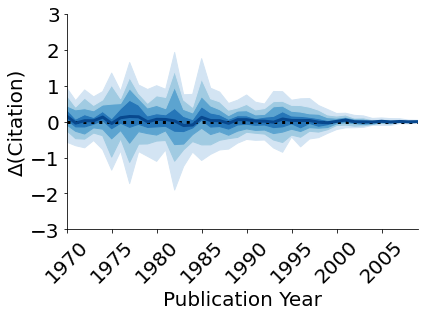

In [24]:
# m-m averaged percentile plot

fig, ax = plt.subplots(figsize=(6,4.5))
right_side = ax.spines["right"]
top_side = ax.spines["top"]
right_side.set_visible(False)
top_side.set_visible(False)

cm2 = sns.color_palette("Blues",10)

plt.axhline(y=0, color='black', linestyle='dotted', lw=3)
plt.plot(paired_mm.lateryear,paired_mm["median"],"-",label="M-M Median", color=cm2[9], lw=3)

plt.fill_between(paired_mm.lateryear, paired_mm["percentile_10"],
                 paired_mm["percentile_20"], color=cm2[1])
plt.fill_between(paired_mm.lateryear, paired_mm["percentile_20"],
                 paired_mm["percentile_30"], color=cm2[3])
plt.fill_between(paired_mm.lateryear, paired_mm["percentile_30"],
                 paired_mm["percentile_40"], color=cm2[5])
plt.fill_between(paired_mm.lateryear, paired_mm["percentile_40"],
                 paired_mm["median"], color=cm2[7])
plt.fill_between(paired_mm.lateryear, paired_mm["median"],
                 paired_mm["percentile_60"], color=cm2[7])
plt.fill_between(paired_mm.lateryear, paired_mm["percentile_60"],
                 paired_mm["percentile_70"], color=cm2[5])
plt.fill_between(paired_mm.lateryear, paired_mm["percentile_70"],
                 paired_mm["percentile_80"], color=cm2[3])
plt.fill_between(paired_mm.lateryear, paired_mm["percentile_80"],
                 paired_mm["percentile_90"], color=cm2[1])

plt.xticks(fontsize=20, rotation=45)
plt.yticks(fontsize=20)
plt.xlabel("Publication Year", fontsize=20)
plt.ylabel("\u0394(Citation)", fontsize=20)

plt.xlim(xmin=1970, xmax=2009)
plt.ylim(ymin=-3, ymax=3)

plt.tight_layout()

### Centrality differences of similar m-m & m-f pairs by year

In [25]:
# mm_ms is the DataFrame for the difference plot (M-M pairs)
mm_ms = mm_centrality.copy()

# Retrieving the list of means and SDs
meanlist = mm_ms.iloc[:,1:].mean(axis=1).tolist()
sdlist = mm_ms.iloc[:,1:].std(axis=1).tolist()

# Appending to the DataFrame
mm_ms['avg'] = meanlist
mm_ms['sd'] = sdlist
mm_ms = mm_ms[['lateryear','avg','sd']]

In [26]:
# mf_ms is the DataFrame for the difference plot (M-F pairs)
mf_ms = simp_mw.groupby("lateryear").agg(['count', np.mean, np.std]).reset_index()

# Retrieve a standard error list for M-F pairs
semlist = []

for i in range(len(mf_ms)):
    semlist.append(mf_ms.countd['std'][i]/math.sqrt(mf_ms.countd['count'][i]))

mf_ms['sem'] = semlist

In [27]:
# remove sparse year data (not used in visualization regardlessly)

mm_ms = mm_ms.loc[4:].reset_index(drop=True)
mf_ms = mf_ms.loc[4:].reset_index(drop=True)

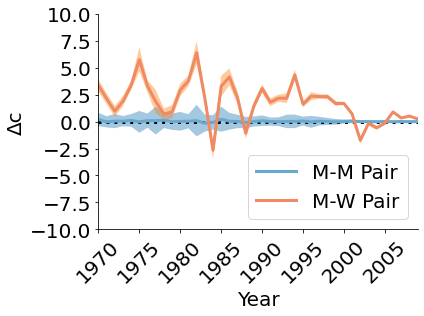

In [28]:
# Creating a year vs. centrality difference plot, separated by gender

fig, ax = plt.subplots(figsize=(6,4.5))
right_side = ax.spines["right"]
top_side = ax.spines["top"]
right_side.set_visible(False)
top_side.set_visible(False)

# Equilibrium line
plt.axhline(y=0, color='black', linestyle='dotted', lw=3)

# Plotting M-M pairs
plt.plot(mm_ms.lateryear,mm_ms.avg,"-",label="M-M Pair",
         color='#67a9cf', lw=3)

# shading the SD area (M-M)
X  = np.linspace(min(mm_ms.lateryear),max(mm_ms.lateryear),mm_ms.lateryear.nunique())
plt.fill_between(X,
                 mm_ms.avg + mm_ms.sd,
                 mm_ms.avg - mm_ms.sd,
                 color='C0',alpha=.4,edgecolor="none")

# Plotting M-F pairs
plt.plot(mf_ms.lateryear,mf_ms.countd['mean'],"-",label="M-W Pair",
         color='#ef8a62', lw=3)

# shading the SE area (M-F)
plt.fill_between(X,
                 mf_ms.countd['mean'] + mf_ms['sem'],
                 mf_ms.countd['mean'] - mf_ms['sem'],
                 color='C1',alpha=.4,edgecolor="none")

plt.xticks(fontsize=20, rotation=45)
plt.yticks(fontsize=20)
plt.xlabel("Year",fontsize=20)
plt.ylabel("\u0394c",fontsize=20)
plt.xlim(xmin=1970, xmax=2009)
plt.ylim(ymin=-10, ymax=10)

plt.legend(loc='lower right', fontsize=20)

plt.tight_layout()

### Year difference vs. Centrality difference visualization by PACS

In [29]:
def sigfig(n):
    if n <= 0.001:
        return '***'
    elif n <= 0.01:
        return '**'
    elif n <= 0.05:
        return '*'
    return 'ns'

In [30]:
# Separate into 4 quadrants depending on count difference and year difference

N = 9  # subfield
sdoi = primdata[primdata[f'pacs{N}0'] == 1].doi

cy_mw = sim_mf.copy()
print(len(cy_mw))
cy_mw = cy_mw[cy_mw['qval'] < 0.001]  # apply threshold
print(len(cy_mw))
cy_mw = cy_mw[(cy_mw.paper1.isin(sdoi)) & (cy_mw.paper2.isin(sdoi))
             ].reset_index(drop=True)  # apply subfield
print(len(cy_mw))

quad1 = cy_mw[(cy_mw.countd > 0) & (cy_mw.yeard > 0)]
quad2 = cy_mw[(cy_mw.countd > 0) & (cy_mw.yeard < 0)]
quad3 = cy_mw[(cy_mw.countd < 0) & (cy_mw.yeard < 0)]
quad4 = cy_mw[(cy_mw.countd < 0) & (cy_mw.yeard > 0)]

14486715
1057052
28262


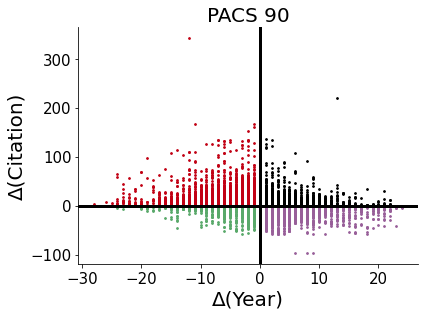

In [31]:
# build scatterplots

fig, ax = plt.subplots(figsize=(6,4.5))
right_side = ax.spines["right"]
top_side = ax.spines["top"]
right_side.set_visible(False)
top_side.set_visible(False)

# Create year difference vs. count difference scatterplot
plt.title(f"PACS {N}0", fontsize=20)
plt.scatter(quad1.yeard, quad1.countd, s=3, c='#000000')
plt.scatter(quad2.yeard, quad2.countd, s=3, c='#c20114')
plt.scatter(quad3.yeard, quad3.countd, s=3, c='#59a96a')
plt.scatter(quad4.yeard, quad4.countd, s=3, c='#985f99')
plt.axhline(y=0, linewidth=0.5, c='k', lw=3)
plt.axvline(x=0, linewidth=0.5, c='k', lw=3)
plt.xlabel("\u0394(Year)", fontsize=20)
plt.ylabel("\u0394(Citation)", fontsize=20)
# plt.ylim(ymax=200)
# plt.xlim(xmin=-25, xmax=25)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()

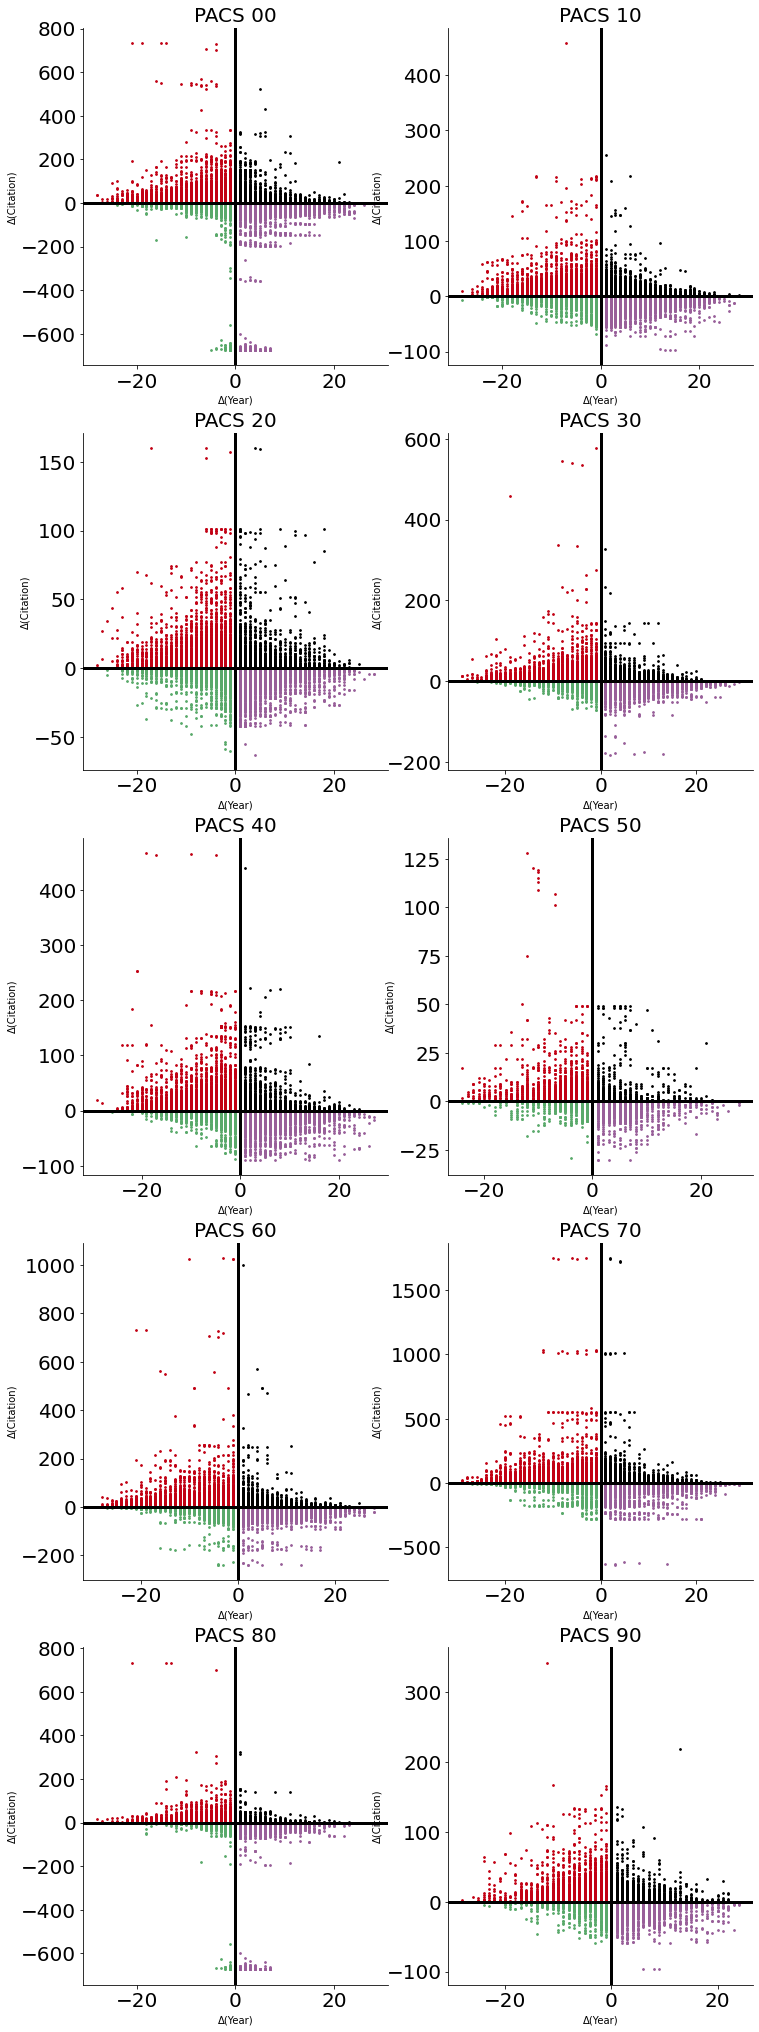

In [32]:
# ALL scatterplots

fig, axs = plt.subplots(5, 2, figsize=(12,36))

for i in range(10):
    N = i  # subfield
    sdoi = primdata[primdata[f'pacs{N}0'] == 1].doi

    cy_mw = sim_mf.copy()
    cy_mw = cy_mw[cy_mw['qval'] < 0.001]  # apply threshold
    cy_mw = cy_mw[(cy_mw.paper1.isin(sdoi)) & (cy_mw.paper2.isin(sdoi))
                 ].reset_index(drop=True)  # apply subfield

    quad1 = cy_mw[(cy_mw.countd > 0) & (cy_mw.yeard > 0)]
    quad2 = cy_mw[(cy_mw.countd > 0) & (cy_mw.yeard < 0)]
    quad3 = cy_mw[(cy_mw.countd < 0) & (cy_mw.yeard < 0)]
    quad4 = cy_mw[(cy_mw.countd < 0) & (cy_mw.yeard > 0)]
    
    (x, y) = divmod(i, 2)
    
    right_side = axs[x, y].spines["right"]
    top_side = axs[x, y].spines["top"]
    right_side.set_visible(False)
    top_side.set_visible(False)
    
    axs[x, y].scatter(quad1.yeard, quad1.countd, s=3, c='#000000')
    axs[x, y].scatter(quad2.yeard, quad2.countd, s=3, c='#c20114')
    axs[x, y].scatter(quad3.yeard, quad3.countd, s=3, c='#59a96a')
    axs[x, y].scatter(quad4.yeard, quad4.countd, s=3, c='#985f99')
    axs[x, y].set_title(f"PACS {N}0", fontsize=20)
    axs[x, y].axhline(y=0, linewidth=0.5, c='k', lw=3)
    axs[x, y].axvline(x=0, linewidth=0.5, c='k', lw=3)
    
    axs[x, y].tick_params(axis="x", labelsize=20)
    axs[x, y].tick_params(axis="y", labelsize=20)
    
for ax in axs.flat:
    ax.set(xlabel='\u0394(Year)', ylabel='\u0394(Citation)')

In [33]:
# Q1 vs. Q3

for i in range(1,11):
    q1 = quad1[quad1['yeard'] == i]
    q3 = quad3[quad3['yeard'] == i * -1]
    if len(q1) < 2 or len(q3) < 2:
        print('NA')
    else:
        xd = q1['countd'].mean() - abs(q3['countd']).mean()
        var = math.sqrt(stdev(q1['countd'])**2/len(q1) +
                    stdev(abs(q3['countd']))**2/len(q3))
        zscore = xd/var
        pval = norm.sf(abs(xd/var))*2
        print(format(zscore, ".4f"), format(pval, ".4f"), sigfig(pval))
        
print('-'* 30)

# Q2 vs. Q4

for i in range(1,11):
    q2 = quad2[quad2['yeard'] == i * -1]
    q4 = quad4[quad4['yeard'] == i]
    if len(q4) < 2 or len(q2) < 2:
        print('NA')
    else:
        xd = q2['countd'].mean() - abs(q4['countd']).mean()
        var = math.sqrt(stdev(q4['countd'])**2/len(q4) +
                    stdev(abs(q2['countd']))**2/len(q2))

        zscore = xd/var
        pval = norm.sf(abs(xd/var))*2
        print(format(zscore, ".4f"), format(pval, ".4f"), sigfig(pval))

5.2232 0.0000 ***
2.2317 0.0256 *
1.8725 0.0611 ns
1.9107 0.0560 ns
1.1279 0.2594 ns
0.5537 0.5798 ns
0.3924 0.6948 ns
1.4787 0.1392 ns
1.7341 0.0829 ns
0.9210 0.3570 ns
------------------------------
4.5563 0.0000 ***
3.4330 0.0006 ***
3.7576 0.0002 ***
2.8860 0.0039 **
2.4969 0.0125 *
4.2551 0.0000 ***
3.0543 0.0023 **
2.1406 0.0323 *
1.2243 0.2208 ns
3.0319 0.0024 **


## Wilcoxon-test

In [40]:
def wlx_test(cts,zero_method="wilcox"):
    men_cts, fem_cts = cts[:,0], cts[:,1]
    T_1, pval = wilcoxon(fem_cts,men_cts,alternative="less",zero_method=zero_method)
    nonzero = len(men_cts[men_cts-fem_cts!=0])
    if zero_method == "wilcox":
        S = nonzero*((nonzero+1)/2.0)
    elif zero_method == "pratt":
        tot_smpls = len(men_cts)
        yeszero = tot_smpls - nonzero
        S = nonzero*((tot_smpls+yeszero+1)/2.0)
    else:
        raise ValueError(f"zero_method {zero_method} not implemented")
    T_2 = S-T_1
    # print (T_2/S, T_1/S)
    ## Sum of difference ranks where men have advantage (T2) minus sum of
    ## difference ranks where women have advantage (T1)
    eff_size = (T_2-T_1)/S
    return {"val":T_2-T_1, "eff_size":eff_size, "p":pval}

In [41]:
# choose dataset

data = primdata.copy() #### IF PRIMARY
# data = lastdata.copy() #### IF LAST

#### PACS
cond = 9
sdoi = data[data[f'pacs{cond}0'] == 1].doi

# print("man-led: ", data.query(f'gender == "male" & pacs{cond}0 == 1').doi.nunique())
# print("woman-led: ", data.query(f'gender == "female" & pacs{cond}0 == 1').doi.nunique())

#### IF PRIMARY

df = sim_mf[sim_mf['paper1'].isin(sdoi)]
df = df[df['paper2'].isin(sdoi)].reset_index(drop=True)

#### IF LAST

# df = sim_mf_last[sim_mf_last['paper1'].isin(sdoi)]
# df = df[df['paper2'].isin(sdoi)].reset_index(drop=True)

In [42]:
# if all datasets (without subfield distinction)

df = sim_mf.copy() #### IF PRIMARY
# df = sim_mf_last.copy() #### IF LAST

In [43]:
# non-time constraint

p = 0.001
df_vld = df[df['qval'] < p]

# print("N: ", len(df))
print("M: ", len(df_vld))
# print("M/N: ", format(len(df_vld)/len(df), ".4f"))

cts = []
for i in tqdm(range(len(df_vld))):
    if df_vld.gender1[i] == 'male':
        cts.append([df_vld.count1[i], df_vld.count2[i]])
    else:
        cts.append([df_vld.count2[i], df_vld.count1[i]])
        
cts = np.array(cts)

wlx_test(cts,zero_method="wilcox")

  1%|          | 6437/1057052 [00:00<00:32, 32457.22it/s]

M:  1057052


100%|██████████| 1057052/1057052 [00:36<00:00, 28738.31it/s]


{'val': 43284040132.0, 'eff_size': 0.10945788188555063, 'p': 0.0}

In [44]:
# 3 year time constraint

N = 3

df = df[df['yeard'] >= -N]
df = df[df['yeard'] <= N].reset_index(drop=True)

p = 0.001
df_vld = df[df['qval'] < p]

# print("N: ", len(df))
print("M: ", len(df_vld))
# print("M/N: ", format(len(df_vld)/len(df), ".4f"))

cts = []
for i in tqdm(range(len(df_vld))):
    if df_vld.gender1[i] == 'male':
        cts.append([df_vld.count1[i], df_vld.count2[i]])
    else:
        cts.append([df_vld.count2[i], df_vld.count1[i]])
        
cts = np.array(cts)

wlx_test(cts,zero_method="wilcox")

  1%|          | 4971/573110 [00:00<00:11, 49703.06it/s]

M:  573110


100%|██████████| 573110/573110 [00:10<00:00, 53341.86it/s]


{'val': 8808941766.0, 'eff_size': 0.07963484294058938, 'p': 0.0}